In [1]:
import uproot as up
import matplotlib.pyplot as plt
import awkward as ak
import pandas as pd
import h5py
import numpy as np
import time
import dill
import importlib
import os
import os.path

import sys
sys.path.insert(0, '/home/mark/work/DarkNu_Codebase_Nov2021/V4_2022/DarkNews-generator/examples')
sys.path.insert(0,'src/')

import DarkNews as dn
from DarkNews import const
from DarkNews.GenLauncher import GenLauncher
import ToyAnalysis.analysis_decay as an


#grab some local bits and bobs
from gLEE_tools import *
import MapBuilder as mb
import MasterTools as mst

#some additional info
uboone_vol=((0.55+254.8)*(115.53+117.47)*(0.1+1036.9))*1.3836*1e-6
print("Volume of MicroBooNE, ",uboone_vol) #-1.504115012818


Volume of MicroBooNE,  85.36524536346


In [2]:
#Give your data dircetory that various required gLEE ntuples are in
datadir ="/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/"
#create the masterHelper object with a unique tag for bookeeping. This is regardless of binning.
masterHelper = mst.MasterTools(datadir,"testM1")


Loading Master Oriringal files @  /home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/
Loading Master Original FIles @  /home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/
Loading master DataFrames from geenration
benchmark correction factors are:  1.1866690240452618 1.180029368575624 1.200214592274678 1.1828676470588235


In [7]:
#Pick a simple 7 dim binning
simple_bins_energy_e_minus = [0,10] #np.linspace(0, 1.5, 20, endpoint=True) 
simple_bins_energy_sum = np.linspace(0, 2, 40, endpoint=True)
simple_bins_delta_theta = np.linspace(0, 180, 40, endpoint=True)
simple_bins_pz_p_e_plus = [-1,1]
simple_bins_pz_p_e_minus = [-1,1]
simple_bins_phi_e_minus = [-180,180] #np.linspace(-180, 180, 20, endpoint=True)
simple_bins_pos_decay_z = np.linspace(-520, 520, 40, endpoint=True)


simple_binning_scheme = (
    simple_bins_energy_e_minus,
    simple_bins_energy_sum,
    simple_bins_delta_theta, 
    simple_bins_pz_p_e_plus, 
    simple_bins_pz_p_e_minus,
    simple_bins_phi_e_minus,
    simple_bins_pos_decay_z 
)

#At this stage we assign the binning, and build the master maps. If you have them premade you can simply load them in the next line
masterHelper.buildMasterMap(simple_binning_scheme, "datafiles_for_mapping/output_maps/")
masterHelper.loadMasterMap("datafiles_for_mapping/output_maps/")

Building map for testM1_BPA
output will be at  datafiles_for_mapping/output_maps//testM1_BPA.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Not including Weights. self._data.shape:  (33559, 7)
Done on  testM1_BPA
Building map for testM1_BPD
output will be at  datafiles_for_mapping/output_maps//testM1_BPD.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Not including Weights. self._data.shape:  (32144, 7)
Done on  testM1_BPD
Building map for testM1_BPC
output will be at  datafiles_for_mapping/output_maps//testM1_BPC.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Not including Weights. self._data.shape:  (33558, 7)
Done on  testM1_BPC
Building map for testM1_BPD
output will be at  datafiles_for_mapping/output_maps//testM1_BPD.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Not including Weights. self._data.shape:  (32174, 7)
Done on  testM1_BPD
loading master maps from  datafiles_for_mapping/output_maps/
Now available to helper as self.map_X


In [9]:

#load a quick test. Precalculated Maps that we want to reproduce
m_TPA = h5py.File("datafiles_for_mapping/TP_maps/TPA_v1.hdf5", "r")
m_TPP = h5py.File("datafiles_for_mapping/TP_maps/TPP_v1.hdf5", "r")
m_TPG = h5py.File("datafiles_for_mapping/TP_maps/TPG_v1.hdf5", "r")
m_TPD = h5py.File("datafiles_for_mapping/TP_maps/TPD_v1.hdf5", "r")


# doing actual reweight using masterhelper

In [10]:
#As you ask for reweights, you populate the internal dataframe with new weights
masterHelper.reweight(m_TPP,"m2TPP")
masterHelper.reweight(m_TPA,"m2TPA")
masterHelper.reweight(m_TPG,"m2TPG")
result = masterHelper.reweight(m_TPD,"m2TPD")



Starting to reweight master map to target, weight name  m2TPP
Apply the map took  134.3955795764923
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  9987
Valid:  33246
Mean Non-zero Weight:  0.003954171804680564
Mean Weight:  0.0030407419290451746
Starting to reweight master map to target, weight name  m2TPA
Apply the map took  135.82576489448547
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  32896
Valid:  10337
Mean Non-zero Weight:  0.01169005583984295
Mean Weight:  0.002795089566221557
Starting to reweight master map to target, weight name  m2TPG
Apply the map took  138.3793601989746
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  34372
Valid:  8861
Mean Non-zero Weight:  0.0015036321833021742
Mean Weight:  0.0003081832113487513
Starting to reweight master map to target, weight name  m2TPD
Apply the map took  114.01448655128479
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  28299
Valid:  149

# This is where we Plot

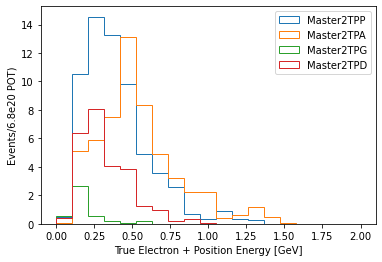

In [12]:
#To use the reweight we then simply plot our master DF with the according weight!

esum_bins=np.linspace(0, 2.0, 20)
plt.hist(result["true_energy_sum"],bins=esum_bins, weights=1.0*result['m2TPP']*result["pass_selection"], histtype=u'step', label='Master2TPP' )
plt.hist(result["true_energy_sum"],bins=esum_bins, weights=1.0*result['m2TPA']*result["pass_selection"], histtype=u'step', label='Master2TPA' )
plt.hist(result["true_energy_sum"],bins=esum_bins, weights=1.0*result['m2TPG']*result["pass_selection"], histtype=u'step', label='Master2TPG' )
plt.hist(result["true_energy_sum"],bins=esum_bins, weights=1.0*result['m2TPD']*result["pass_selection"], histtype=u'step', label='Master2TPD' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True Electron + Position Energy [GeV]')
#plt.yscale('log')
#plt.savefig('simple_test_truth_BPD_to_TPD.pdf')  
plt.show()
